In [1]:
import sys
sys.path.insert(1, '../')
import torch
from spiral.analysis import FunctionGenerator, Simulator
import matplotlib.pyplot as plt
from matplotlib_dashboard import MatplotlibDashboard

from spiral import (
    IntegrateAndFireSoma,
    LeakyMembrane,
    LinearDendrite,
    Axon,
    ConvergentSynapticPlasticity,
    Synapse,
    DisconnectorSynapticCover,
    RandomFixedPresynapticPartnersConnectivity,
    AutapseConnectivity,
    InvertConnectivity,
    ScalingResponseFunction,
    Network,
)
LIF = (LeakyMembrane(IntegrateAndFireSoma))
from spiral.operators import *

In [2]:
CONSIDER | Network(dt=1., batch=2)
###################################################
INSERT | LIF(name='A', shape=(4,), analyzable=True)
INSERT | LIF(name='B', shape=(2,), analyzable=True)
###################################################
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=RandomFixedPresynapticPartnersConnectivity(rate=.5)
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=100.),
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['A']
    ) | TO | (
        LinearDendrite(
            plasticity_model=ConvergentSynapticPlasticity(tau=100),
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['B']
    )
)
###################################################
INSERT | (
    (
        Synapse()
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=100.),
            delay=25.,
            terminal=(2,),
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['A']
    ) | TO | (
        LinearDendrite(
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['B']
    )
)
###################################################
net = CHECKOUT | CONSIDERED.NETWORK

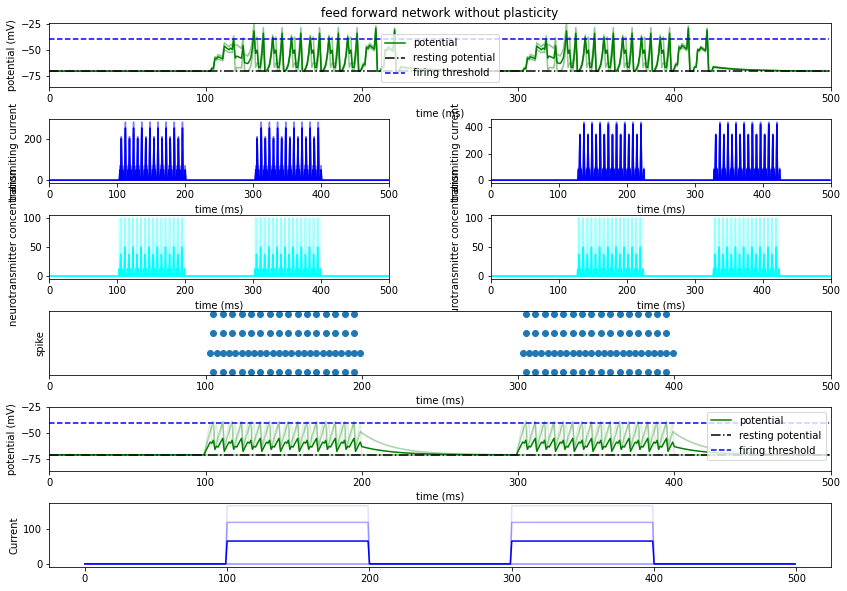

In [3]:
I = FunctionGenerator.generate(500, shape=(2, 4,),
           baseline={100*i: 120 if i%2 else 0 for i in range(5)})
I[:,:,1] *= 1.4
I[:,1] = 0

net.plasticity = False
net.reset()
sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(14,10))
md = MatplotlibDashboard([
        ['U2','U2'],
        ['D1','D2'],
        ['A1','A2'],
        ['S1','S1'],
        ['U1','U1'],
        ['I','I'],
    ], hspace=.5, wspace=.3)

md['I'].plot(I.reshape(I.shape[0], -1), alpha=1/I[0].numel(), color='blue')
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_ylabel('Current')
net['A'].plot_potential(md['U1'])
net['A'].plot_spikes(md['S1'])
net['A']['A_Axon_0'].plot_neurotransmitter(md['A1'])
net['A']['A_Axon_1'].plot_neurotransmitter(md['A2'])
net['B']['B_LinearDendrite_0'].plot_transmiting_current(md['D1'])
net['B']['B_LinearDendrite_1'].plot_transmiting_current(md['D2'])
net['B'].plot_potential(md['U2'])
md['U2'].set_title('feed forward network without plasticity')
plt.show()

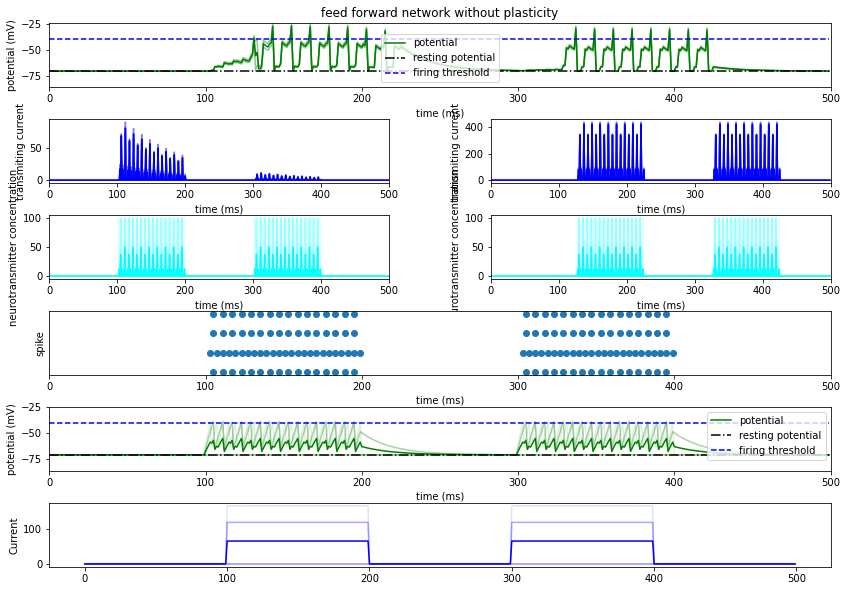

In [4]:
I = FunctionGenerator.generate(500, shape=(2, 4,),
           baseline={100*i: 120 if i%2 else 0 for i in range(5)})
I[:,:,1] *= 1.4
I[:,1] = 0

net.plasticity = True
net.reset()
sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(14,10))
md = MatplotlibDashboard([
        ['U2','U2'],
        ['D1','D2'],
        ['A1','A2'],
        ['S1','S1'],
        ['U1','U1'],
        ['I','I'],
    ], hspace=.5, wspace=.3)

md['I'].plot(I.reshape(I.shape[0], -1), alpha=1/I[0].numel(), color='blue')
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_ylabel('Current')
net['A'].plot_potential(md['U1'])
net['A'].plot_spikes(md['S1'])
net['A']['A_Axon_0'].plot_neurotransmitter(md['A1'])
net['A']['A_Axon_1'].plot_neurotransmitter(md['A2'])
net['B']['B_LinearDendrite_0'].plot_transmiting_current(md['D1'])
net['B']['B_LinearDendrite_1'].plot_transmiting_current(md['D2'])
net['B'].plot_potential(md['U2'])
md['U2'].set_title('feed forward network without plasticity')
plt.show()

In [5]:
CONSIDER | Network()

INSERT | LIF(name='A', shape=(10,), analyzable=True)
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=InvertConnectivity(AutapseConnectivity)()
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=140.),
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['A']
    ) | TO | (
        LinearDendrite(
            analyzable=True
        ) |OF| CONSIDERED.NETWORK['A']
    )
)

net = CHECKOUT | CONSIDERED.NETWORK

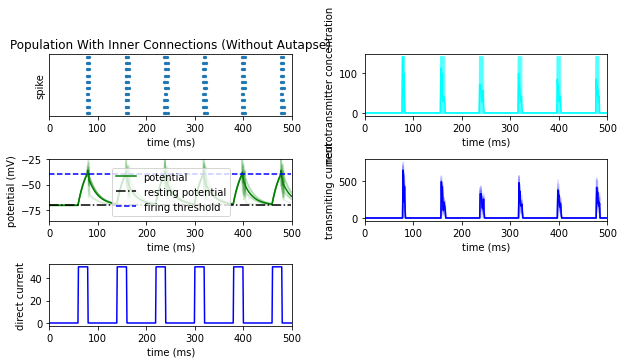

In [6]:
I = FunctionGenerator.generate(500, shape=(1, 10,),
                               baseline={20*i: 50.*(i%4==3) for i in range(25)})
net.reset()
sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(10,5))
md = MatplotlibDashboard([
        ['S','A'],
        ['U','D'],
        ['I',None],
    ], hspace=.7, wspace=.3)

net['A'].plot_potential(md['U'])
net['A'].plot_spikes(md['S'], s=5)
net['A']['A_Axon_0'].plot_neurotransmitter(md['A'])
net['A']['A_LinearDendrite_1'].plot_transmiting_current(md['D'])
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_xlim((0,500))
md['I'].set_xlabel('time (ms)')
md['I'].set_ylabel('direct current')
md['S'].set_title('Population With Inner Connections (Without Autapse)')
plt.show()